In [14]:
import pandas as pd
import numpy as np

from sklearn.decomposition import NMF, LatentDirichletAllocation # DETECCIÓN DE TOPICOS:NMF LDA
from sklearn.feature_extraction.text import CountVectorizer
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

from nltk import word_tokenize
from nltk.corpus import stopwords
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer

from wordcloud import WordCloud
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [2]:
provedores = pd.read_csv('contrataciones_por_proveedor.csv',sep=';')

In [3]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {}:".format(topic_idx+1))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [4]:
def tokenizar(x):
    tokens = word_tokenize(x)
    stopw = [w.encode('utf-8') for w in stopwords.words('spanish')]
    stopw.extend([b'.', b'[', ']', b',', b';', b'', b')', b'),', b' ', b'(', b':', b'?', b'+', b'-' ])#, b'adquisicion'])
    stemmer = SnowballStemmer('spanish')
    stemmers = [stemmer.stem(token) for token in tokens]
    stems = [stem for stem in stemmers if stem.isalpha() and len(stem) > 1]
    final = [stemmed_word.lower()
     for stemmed_word in stems if stemmed_word.lower().encode('utf-8') not in stopw]
    
    return final

In [5]:
def obtenerFrecuenciaPalabras(matrizFreq, clusters_indexados):
    matrizFreq["categoria"] = clusters_indexados
    cluster_freq_grouped = matrizFreq.groupby(by=['categoria']).sum()
    cluster_freq_grouped_transpose = cluster_freq_grouped.transpose()
    return cluster_freq_grouped_transpose.to_dict() 

In [6]:
cv = CountVectorizer(tokenizer=tokenizar, strip_accents="unicode",max_df=0.8)
data_cv = cv.fit_transform(provedores["Objeto contractual"])
data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())

In [8]:
pca = PCA(n_components=0.7, svd_solver ='full')
pca.fit(data_dtm)
data_pca = pca.transform(data_dtm)

In [9]:
data_pca.shape

(19618, 131)

KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x1c291a8e90>,
                 k=None, locate_elbow=True, metric='distortion', model=None,
                 timings=True)

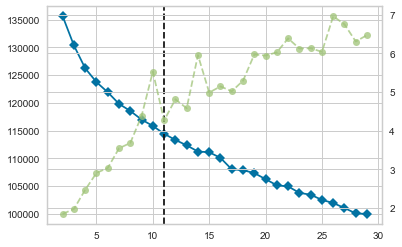

In [10]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,30))
visualizer.fit(data_pca)


In [11]:
model = KMeans(11)
model.fit(data_pca)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=11, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [12]:
data_cluster_pca = provedores.copy()
data_cluster_pca["categoria"] = model.predict(data_pca)
freq_dict_cluster_pca = obtenerFrecuenciaPalabras(data_dtm, data_cluster_pca["categoria"])

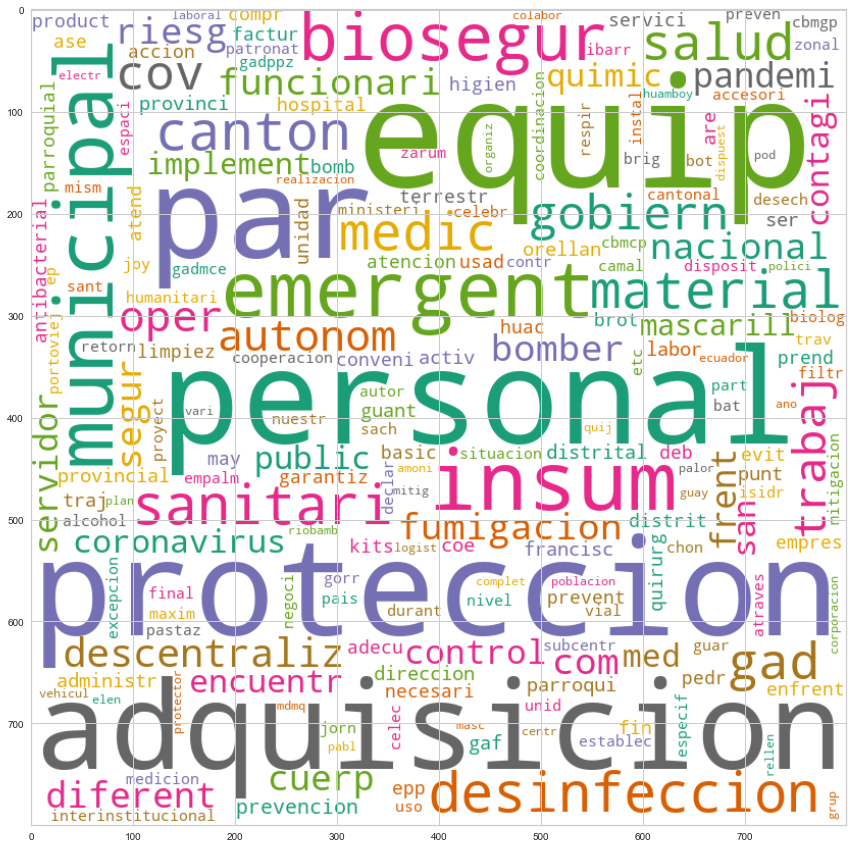

In [55]:
wc = WordCloud(background_color="white", colormap="Dark2",
               max_font_size=150,width=800, height=800)

wc.generate_from_frequencies(freq_dict_cluster_pca[10])
plt.figure(figsize=(15,15))
plt.imshow(wc, interpolation="bilinear")
plt.show()

In [19]:
provedores["categoria"] = data_cluster_pca["categoria"]

In [30]:
provedores.to_csv("contrataciones_por_proveedor_clustered.csv", sep=";")

In [56]:
provedores[provedores["categoria"] == 10]

,Proveedor,Entidad Contratante,Código de resolución,Código de contratación,Objeto contractual,Unidad de medida,Cantidad,Descripción compra por ítem,Precio unitario,Precio total,categoria
210,D&V MEDICAL S.A. IMCONCOM S.A.,GOBIERNO AUTONOMO DESCENTRALIZADO MUNICIPALIDA...,DA-20-023,DA-20-023-00003,ADQUISICIÓN DE EQUIPOS DE PROTECCION PERSONAL...,Unidad,7000.0,TRAJES DE BIO SEGURIDAD,22.32,156240.00,10
226,INCALSID CIA. LTDA.,GOBIERNO AUTÓNOMO DESCENTRALIZADO MUNICIPAL DE...,046-2020,046-2020-00005,REQUERIMIENTO DE EQUIPOS DE PROTECCION PERSONA...,Unidad,10000.0,CONTRATO Nro. 0074-PS-2020,14.50,145000.00,10
230,IPIALES ALDAS LORENA DEL ROCIO,GAD PROVINCIAL DE NAPO,045-GADPN,045-GADPN-00003,"ADQUISICIÓN DE INSUMOS, EQUIPOS DE FUMIGACIÓN ...",Unidad,1.0,INSUMOS Y EQUIPOS PARA LA EMERGENCIA SANITARIA,143291.45,143291.45,10
259,SILVERTI S.A.,EMPRESA PÚBLICA METROPOLITANA DE AGUA POTABLE ...,2020-035,2020-035-00004,ADQUISICIÓN POR EMERGENCIA DE LOS EQUIPOS DE P...,Unidad,4000.0,EQUIPOS DE PROTECCIÓN PERSONAL OPERATIVO EPMAPS,30.00,120000.00,10
275,IMPORTADORA GLOBAL TEXANA IMPORGLOBALTEX S.A.,GOBIERNO AUTÓNOMO DESCENTRALIZADO MUNICIPAL DE...,046-2020,046-2020-00009,ADQUISICION DE EQUIPOS DE PROTECCIÓN PERSONAL ...,Unidad,4000.0,ORDEN DE COMPRA,28.00,112000.00,10
...,...,...,...,...,...,...,...,...,...,...,...
19074,SANCHEZ DIAS LOURDES MARIA,GOBIERNO AUTONOMO DESCENTRALIZADO DE LA PARROQ...,007-2020-GADPPOZUL,007-2020-GADPPOZUL-00001,"IMLEMENTACIÓN DE INSUMOS QUÍMICOS, EQUIPOS SAN...",Unidad,4.0,PARES DE GAFAS TRANSPARENTES MODELO 529B,2.00,8.00,10
19082,MV IMPORTACIONES MV-IMP CIA. LTDA.,CORPORACION ELECTRICA DEL ECUADOR CELEC EP,CEL-RES-0045-20-MAT,CEL-RES-0045-20-MAT-00003,ADQUISICIÓN DE EQUIPOS DE PROTECCIÓN PERSONAL ...,Unidad,50.0,SEGUN ESPECIFICACIONES TECNICAS ELABORADAS POR...,0.16,8.00,10
19170,JORGE JARAMILLO E HIJOS OROCENTRO C.LTDA.,GOBIERNO AUTONOMO DESCENTRALIZADO MUNICIPAL DE...,02-GADM-Z-JL,02-GADM-Z-JL-00003,ADQUISICIÓN DE EQUIPOS DE PROTECCIÓN Y SEGURID...,Unidad,2.0,Protector Facial transparente,3.27,6.54,10
19425,CASTRO MENENDEZ TANYI MARGARITA,JUNTA PARROQUIAL GUARE,GADPRG-COVID001-2020,GADPRG-COVID001-2020-00002,ADQUISICIÓN DE EQUIPOS DE PROTECCIÓN Y DESINFE...,Unidad,1.0,GAFAS DE PROTECCION,3.00,3.00,10


## Grupos 

* **Grupo 0:** Kits alimenticios y productos de primera necesidad 
* **Grupo 1:** Medicamentos e insumos médicos a hospitales
* **Grupo 2:** Compra de mascarillas, guantes y elementos de protección de personal
* **Grupo 3:** Insumos médicos y de protección y desinfección (agrupados por la palabra emergencia e Insumos, esto puede indicar que fueron compras hechas al inicio)
* **Grupo 4:** Kits alimenticios e insumos. Diferenciados del grupo 0 por nombres largos, parecidos y específicos.
* **Grupo 5:** Compra de prendas y accesorios de protección para personal no hospitalario
* **Grupo 6:** Compra insumos de protección, medicinas, bioseguridad. (Agrupados por tener nombres cortos y específicos. Ej. "ADQUISICION DE KIT DE PROTECCION")
* **Grupo 7:** Compra insumos de protección, medicinas, bioseguridad hecho a nivel cantonal, provincial o de parroquia. (Muchos outliers).
* **Grupo 8:** Compras para emergencia sanitaria no limitadas a insumos del grupo 3.  (No contienen la palabra "Insumo",agrupados por la palabra emergencia, esto puede indicar que fueron compras hechas al inicio)
* **Grupo 9:** Compras catalogadas como dispositivos médicos (respiradores, jeringas, etc). (Pueden incluir mascarillas, alcohol, etc con objeto contractual que incluya las palabras "dispositivos médicos"  )
* **Grupo 10:** Compras catalogadas como equipos de protección de personal. Esto puede incluir equipos de desinfección, mascarillas, trajes, etc. (Se diferencian por tener las palabras "EQUIPOS DE PROTECCIÓN")